In [1]:
!nvidia-smi

Sun Oct 24 11:13:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q -U watermark

In [3]:

%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.9.0+cu111
transformers: not installed



In [4]:
#@title Setup & Config
!pip install transformers
!git clone https://github.com/aub-mind/arabert
!pip install -r arabert/requirements.txt
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

     |████████████████████████████████| 2.9 MB 4.2 MB/s 
     |████████████████████████████████| 895 kB 38.1 MB/s 
     |████████████████████████████████| 56 kB 5.1 MB/s 
     |████████████████████████████████| 596 kB 52.4 MB/s 
     |████████████████████████████████| 3.3 MB 39.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Cloning into 'arabert'...
remote: Enumerating objects: 552, done.
remote: Counting objects: 100% (338/338), done.
remote: Compressing objects: 100% (243/243), done.
remote: Total 552 (delta 180), reused 239 (delta 89), pack-reused 214
Receiving objects: 100% (552/552), 9.15 MiB | 10.71 MiB/s, done.
Resolving deltas: 100% (303/303), done.
     |████████████████████████████████| 126 kB 2.8 MB/s 


device(type='cuda', index=0)

In [5]:
from transformers import AutoTokenizer, AutoModel
from arabert.preprocess import ArabertPreprocessor
!git clone https://github.com/aub-mind/arabert
!pip install -r arabert/requirements.txt
from google.colab import files
uploaded = files.upload()

fatal: destination path 'arabert' already exists and is not an empty directory.


Saving let-mi_train_part.csv to let-mi_train_part.csv


In [6]:
df = pd.read_csv("/content/let-mi_train_part.csv")
df.head()

,text,category,misogyny,target
0,@AhmadMoussaly @DimaSadek اي نحن ما منقبلها صر...,discredit,misogyny,active
1,@berrynawal نوال شو قصتك كل يوم بتاكلي قتله شو...,none,none,none
2,@DimaSadek انشالله بيقبر قلبك عن قريب ...يافهي...,damning,misogyny,active
3,@DimaSadek @LBCI_NEWS @JeanFeghali يسلم لسانك ...,none,none,none
4,@RammalNaima @DimaSadek من بجيب الحشيش عبيروت ...,none,none,none


In [7]:
df.shape

(5240, 4)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


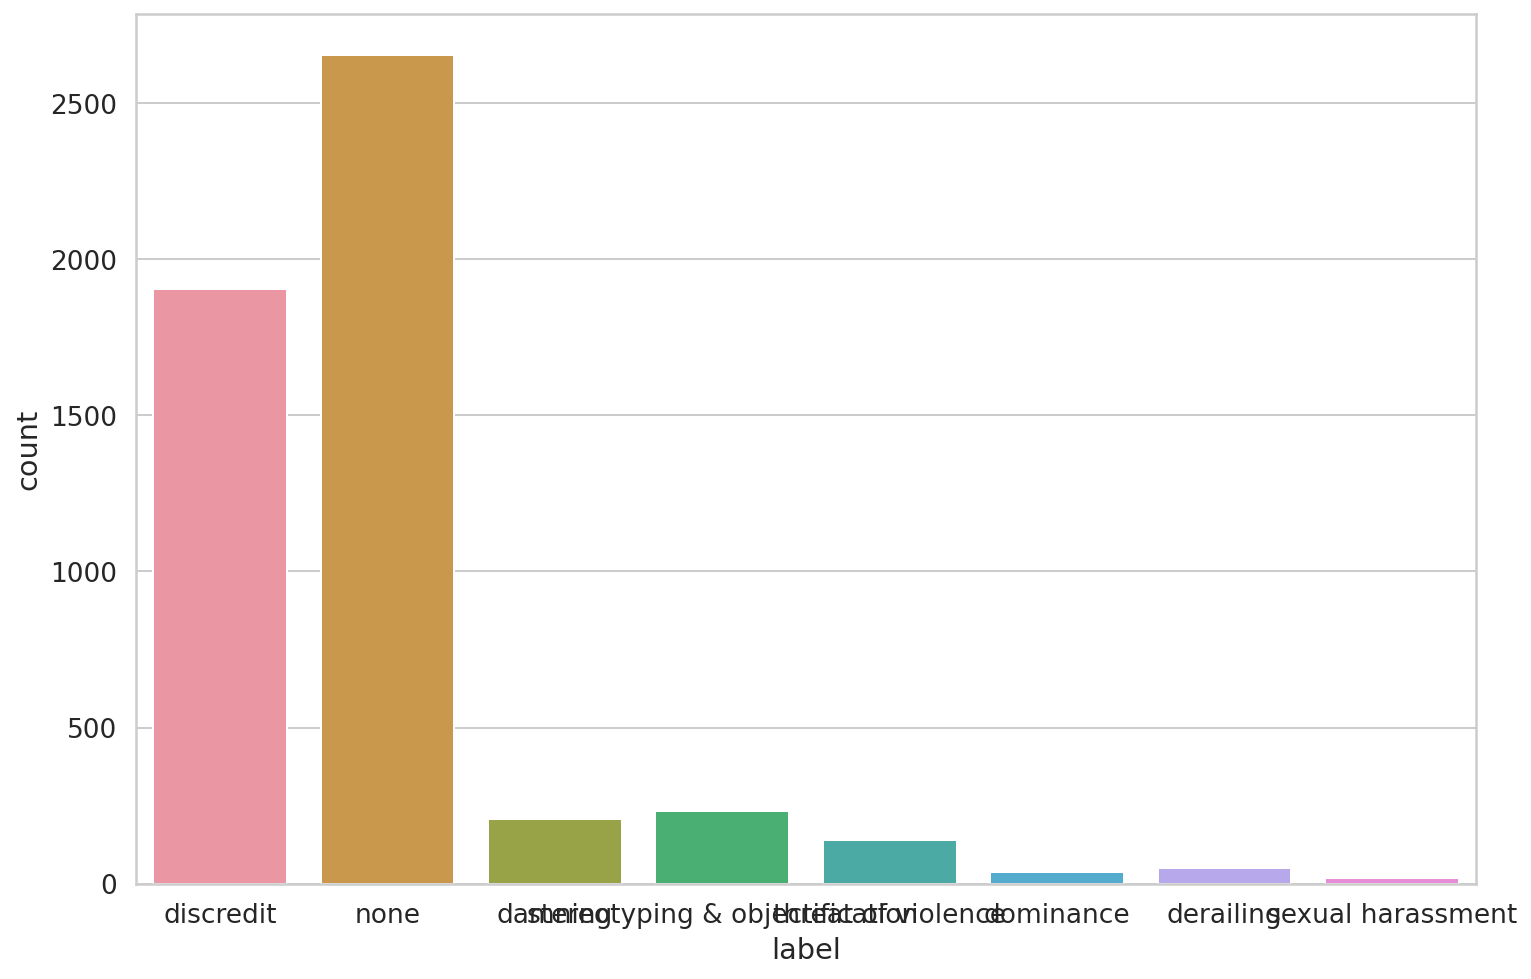

In [8]:
sns.countplot(df.category)
plt.xlabel('label');

In [9]:
df = df.loc[df["category"] != "none"]

In [10]:
df.shape

(2586, 4)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


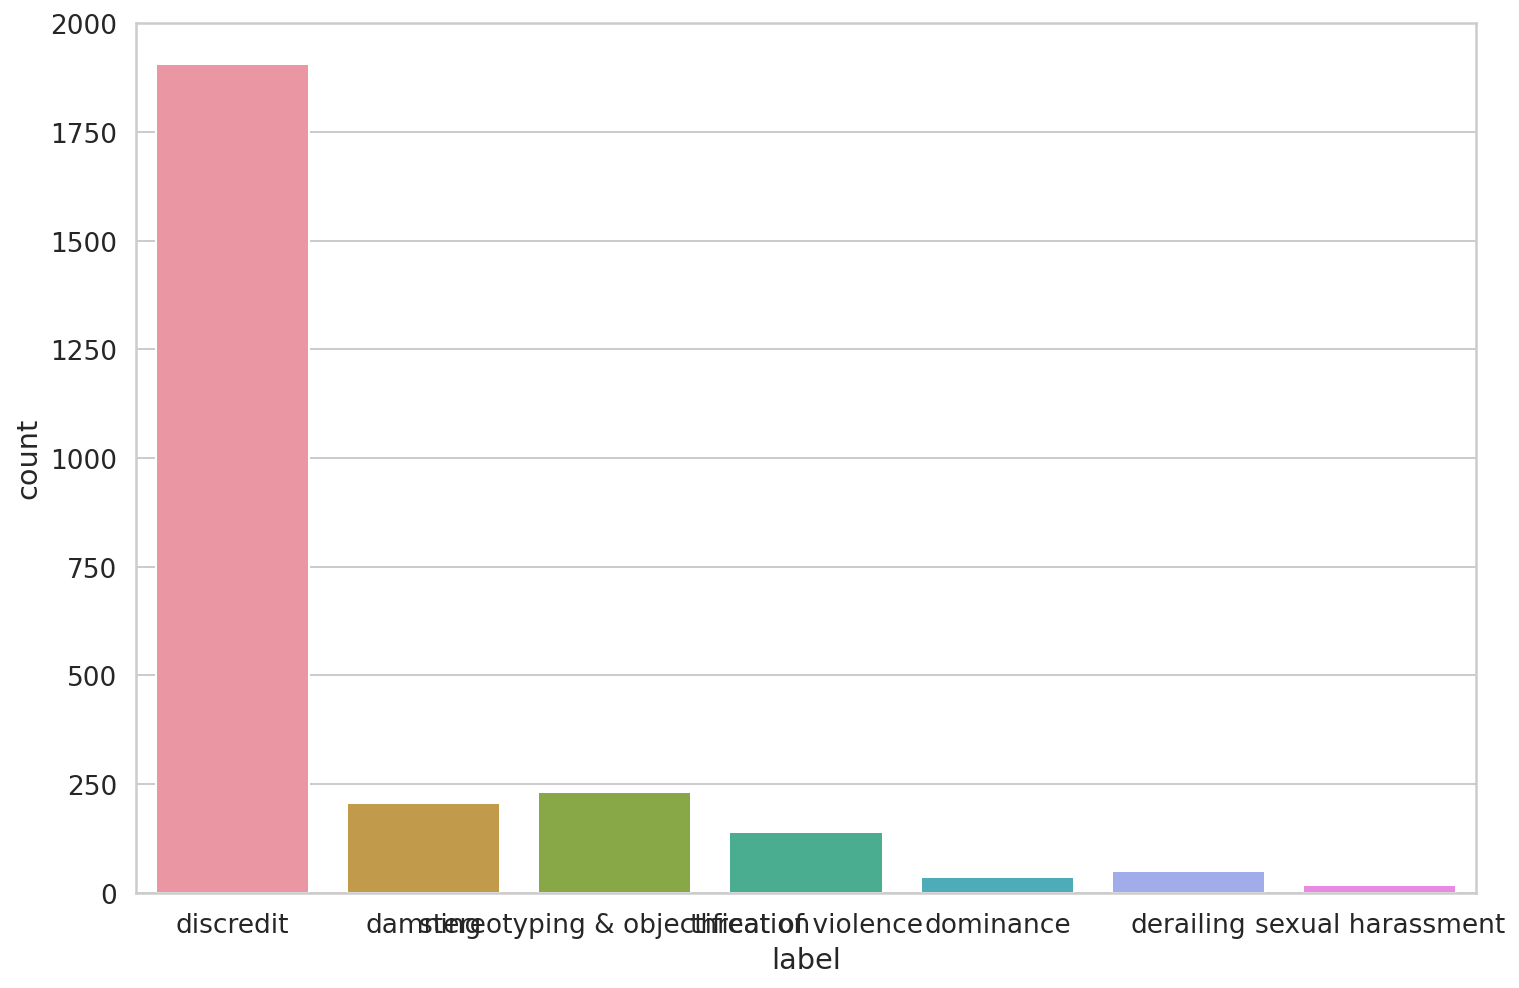

In [11]:
sns.countplot(df.category)
plt.xlabel('label');

In [12]:

def to_int_misogony(value):
  if value =='discredit':
    return 0
  elif value =='damning':
    return 1
  elif value =='stereotyping & objectification':
    return 2
  elif value =='threat of violence':
    return 3
  elif value =='dominance':
    return 4
  elif value =='derailing':
    return 5
  elif value =='sexual harassment':
    return 6

df['labelCategory'] = df.category.apply(to_int_misogony)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


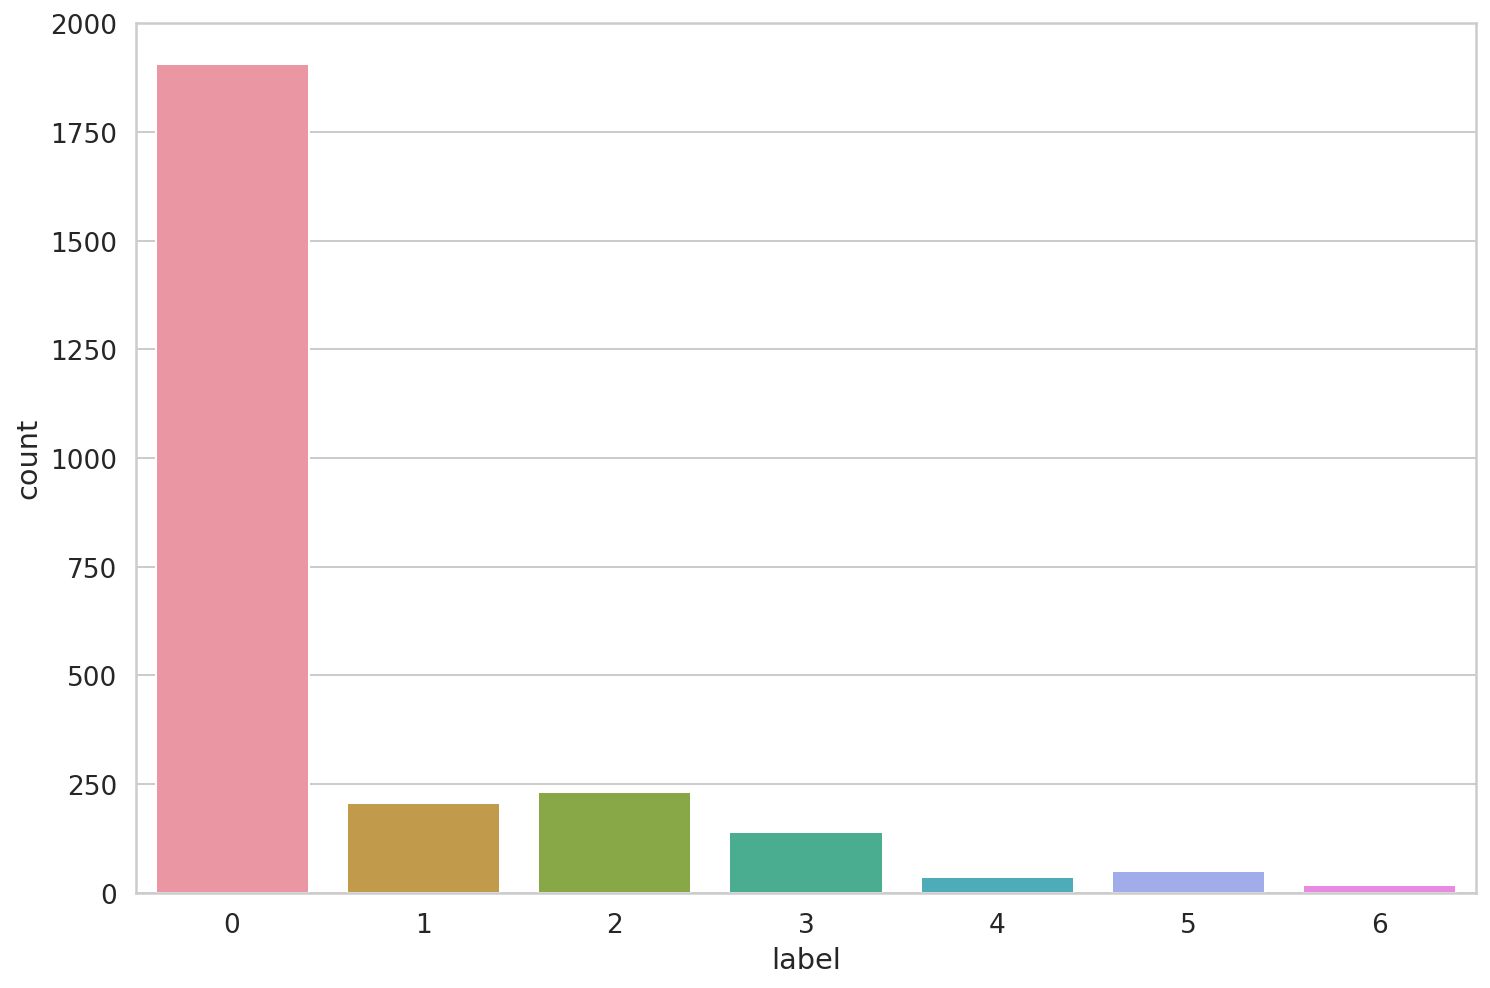

In [13]:
sns.countplot(df.labelCategory)
plt.xlabel('label');

In [25]:
df.head(40)

,text,category,misogyny,target,labelCategory
0,@AhmadMoussaly @DimaSadek اي نحن ما منقبلها صر...,discredit,misogyny,active,0
2,@DimaSadek انشالله بيقبر قلبك عن قريب ...يافهي...,damning,misogyny,active,1
7,@DimaSadek انك بكل تواضع سفيهة منحطة عديمة الم...,discredit,misogyny,active,0
8,@DimaSadek ضبي لسانك احسنلك ��,discredit,misogyny,active,0
9,@DimaSadek يا حمارة يا صهيونية يا عاهرة هؤلاء ...,discredit,misogyny,active,0
13,@DimaSadek ديما لحزب وقع طيارة لأهلك بقصد إسرا...,discredit,misogyny,active,0
14,@berrynawal ابكي بترتاحي,stereotyping & objectification,misogyny,active,2
15,@DimaSadek السيد يا حمارة,discredit,misogyny,active,0
16,@DimaSadek انشا الله ليقبر قلبك,damning,misogyny,active,1
18,@bird99_b @DimaSadek بس يا بهلة,discredit,misogyny,active,0


In [26]:
class_names = ['discredit','damning','stereotyping & objectification','threat of violence','dominance','derailing','sexual harassment']

In [27]:
PRE_TRAINED_MODEL_NAME = 'aubmindlab/bert-base-arabertv2'

In [28]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [29]:
sample_txt = 'شام يا ذا السيف انت السيف لم يغب'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: شام يا ذا السيف انت السيف لم يغب
   Tokens: ['شام', 'يا', 'ذا', 'السي', '##ف', 'انت', 'السي', '##ف', 'لم', 'يغب']
Token IDs: [4530, 1827, 6210, 14863, 246, 442, 14863, 246, 462, 26230]


In [30]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=512,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [31]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

512


tensor([   33,  4530,  1827,  6210, 14863,   246,   442, 14863,   246,   462,
        26230,    34,    31,    31,    31,    31,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31,    31, 

In [32]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

512


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0

In [33]:
token_lens = []

for txt in df.text:
  tokens = tokenizer.encode(txt,max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


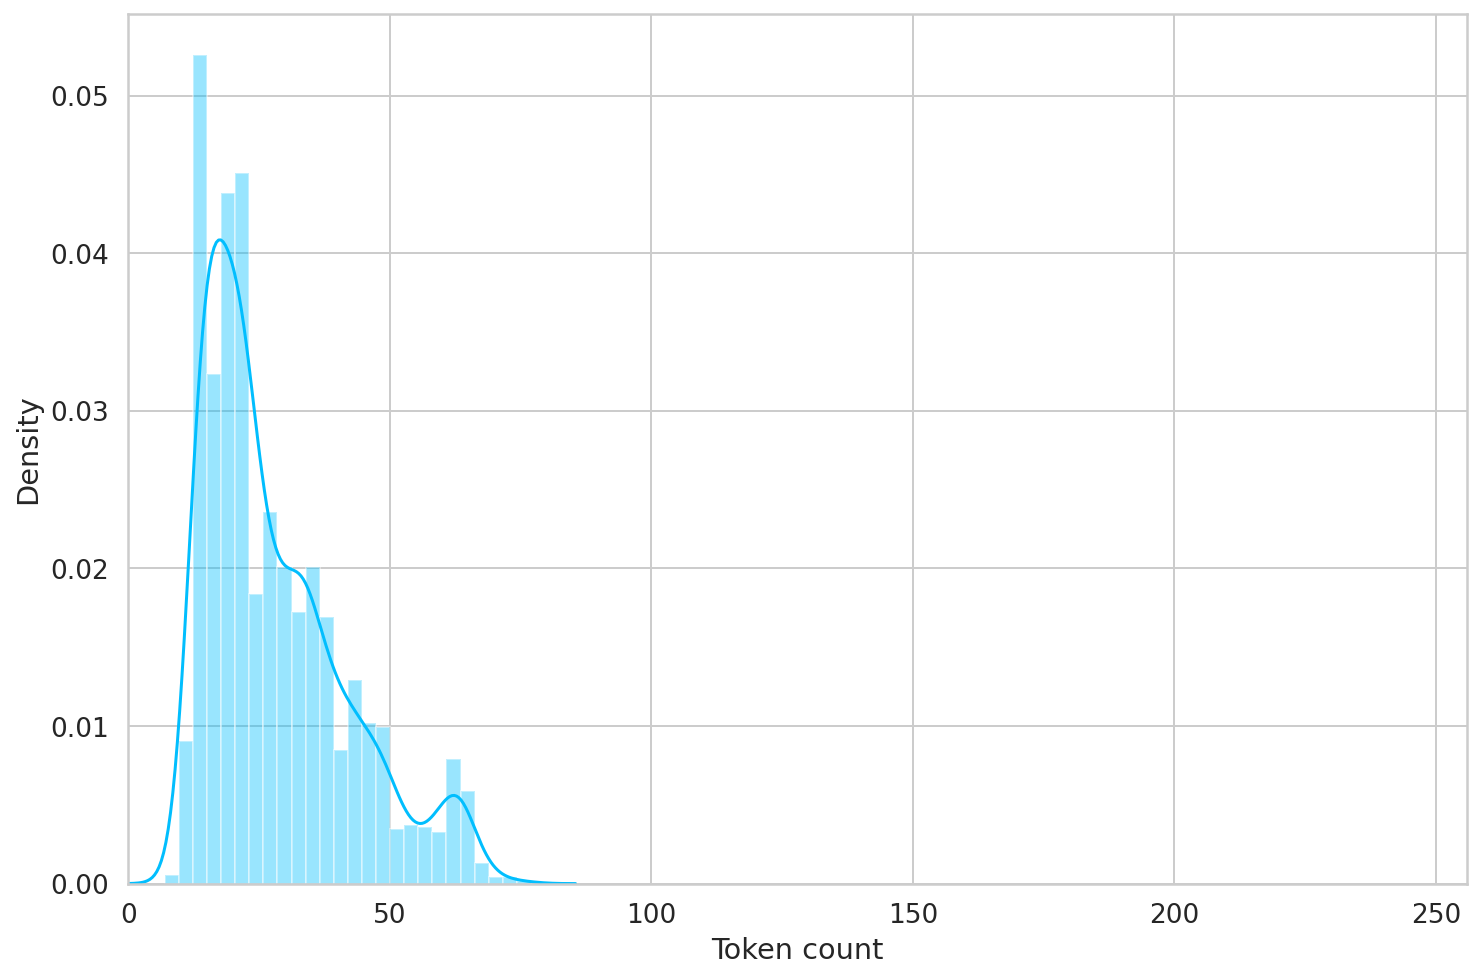

In [34]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [35]:
df.text

0       @AhmadMoussaly @DimaSadek اي نحن ما منقبلها صر...
2       @DimaSadek انشالله بيقبر قلبك عن قريب ...يافهي...
7       @DimaSadek انك بكل تواضع سفيهة منحطة عديمة الم...
8                          @DimaSadek ضبي لسانك احسنلك ��
9       @DimaSadek يا حمارة يا صهيونية يا عاهرة هؤلاء ...
                              ...                        
5231    @DimaSadek يا بلا أخلاق أنتي سباب فتنه يقطع عم...
5232    @Brown_Sailor14 @DimaSadek ديما الشرشوحه ديما ...
5233    @DimaSadek فيكي توقفي استفراغ سمومك وتريحينا م...
5235                              @berrynawal تفه يا نوال
5236           @Asadlassa1 @DimaSadek هي هبلة الله يشفيها
Name: text, Length: 2586, dtype: object

In [36]:
class HateSpeechDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=80,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [37]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [38]:
df_train.shape, df_val.shape, df_test.shape

((2068, 5), (259, 5), (259, 5))

In [39]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = HateSpeechDataset(
    reviews=df.text.to_numpy(),
    targets=df.labelCategory.to_numpy(),
    tokenizer=tokenizer,
    max_len=80
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [40]:
BATCH_SIZE = 8
MAX_LEN=80
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [41]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [42]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([8, 80])
torch.Size([8, 80])
torch.Size([8])


In [43]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/518M [00:00<?, ?B/s]

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [44]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask'],return_dict=False
) 

In [45]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [46]:
class misogynyClassifier(nn.Module):

  def __init__(self, n_classes):
    super(misogynyClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [47]:
model = misogynyClassifier(len(class_names))
model = model.to(device)
print(len(class_names))

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


7


In [53]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [54]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [55]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [57]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(10):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.3974521330802281 accuracy 0.8921663442940039
Val   loss 0.8917917312602653 accuracy 0.7837837837837838

Epoch 2/10
----------
Train loss 0.3142563551700311 accuracy 0.9226305609284333
Val   loss 1.0257958944350707 accuracy 0.7760617760617761

Epoch 3/10
----------
Train loss 0.24924013108953574 accuracy 0.9376208897485493
Val   loss 1.1464796541329247 accuracy 0.7837837837837838

Epoch 4/10
----------
Train loss 0.18484261934465682 accuracy 0.9564796905222437
Val   loss 1.0821609393354843 accuracy 0.7760617760617761

Epoch 5/10
----------
Train loss 0.14773717972191058 accuracy 0.965183752417795
Val   loss 1.1945595679289633 accuracy 0.7837837837837838

Epoch 6/10
----------
Train loss 0.11605565063475584 accuracy 0.9743713733075435
Val   loss 1.1917810382032203 accuracy 0.7915057915057915

Epoch 7/10
----------
Train loss 0.110015213961037 accuracy 0.9758220502901354
Val   loss 1.2404005602813524 accuracy 0.7837837837837838

Epoch 8/10
----------
Tra

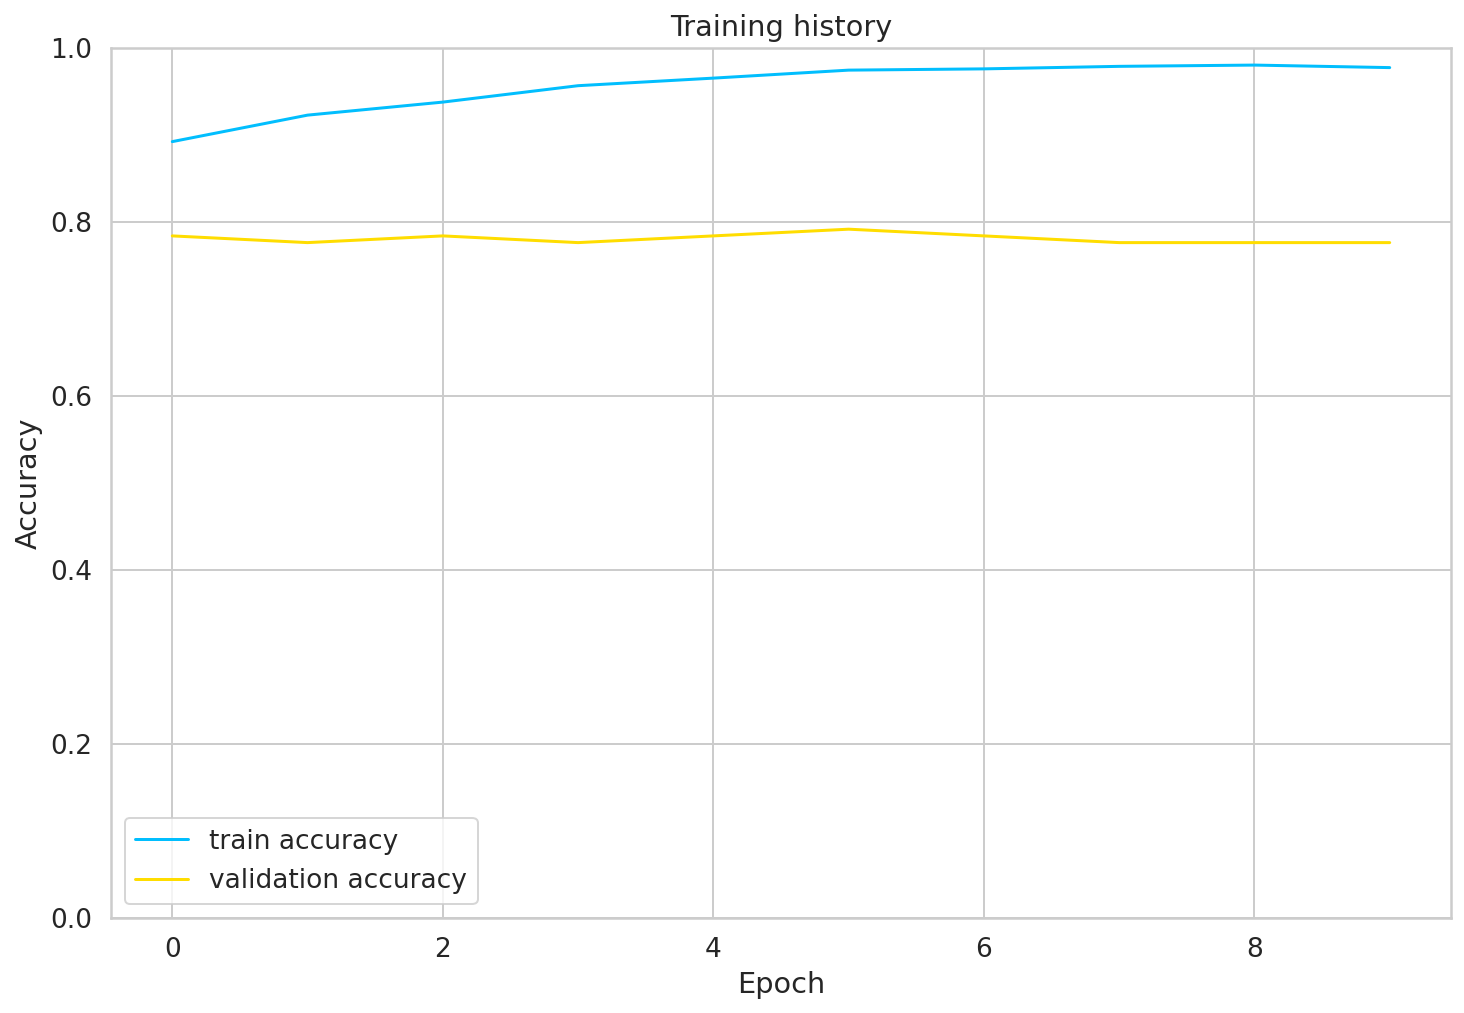

In [58]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [59]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.7760617760617761

In [60]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [61]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [62]:
print(classification_report(y_test, y_pred, target_names=class_names))

                                precision    recall  f1-score   support

                     discredit       0.85      0.91      0.88       181
                       damning       0.84      0.80      0.82        20
stereotyping & objectification       0.60      0.55      0.57        22
            threat of violence       0.54      0.35      0.42        20
                     dominance       0.00      0.00      0.00         6
                     derailing       0.14      0.14      0.14         7
             sexual harassment       0.00      0.00      0.00         3

                      accuracy                           0.78       259
                     macro avg       0.42      0.39      0.41       259
                  weighted avg       0.75      0.78      0.76       259



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


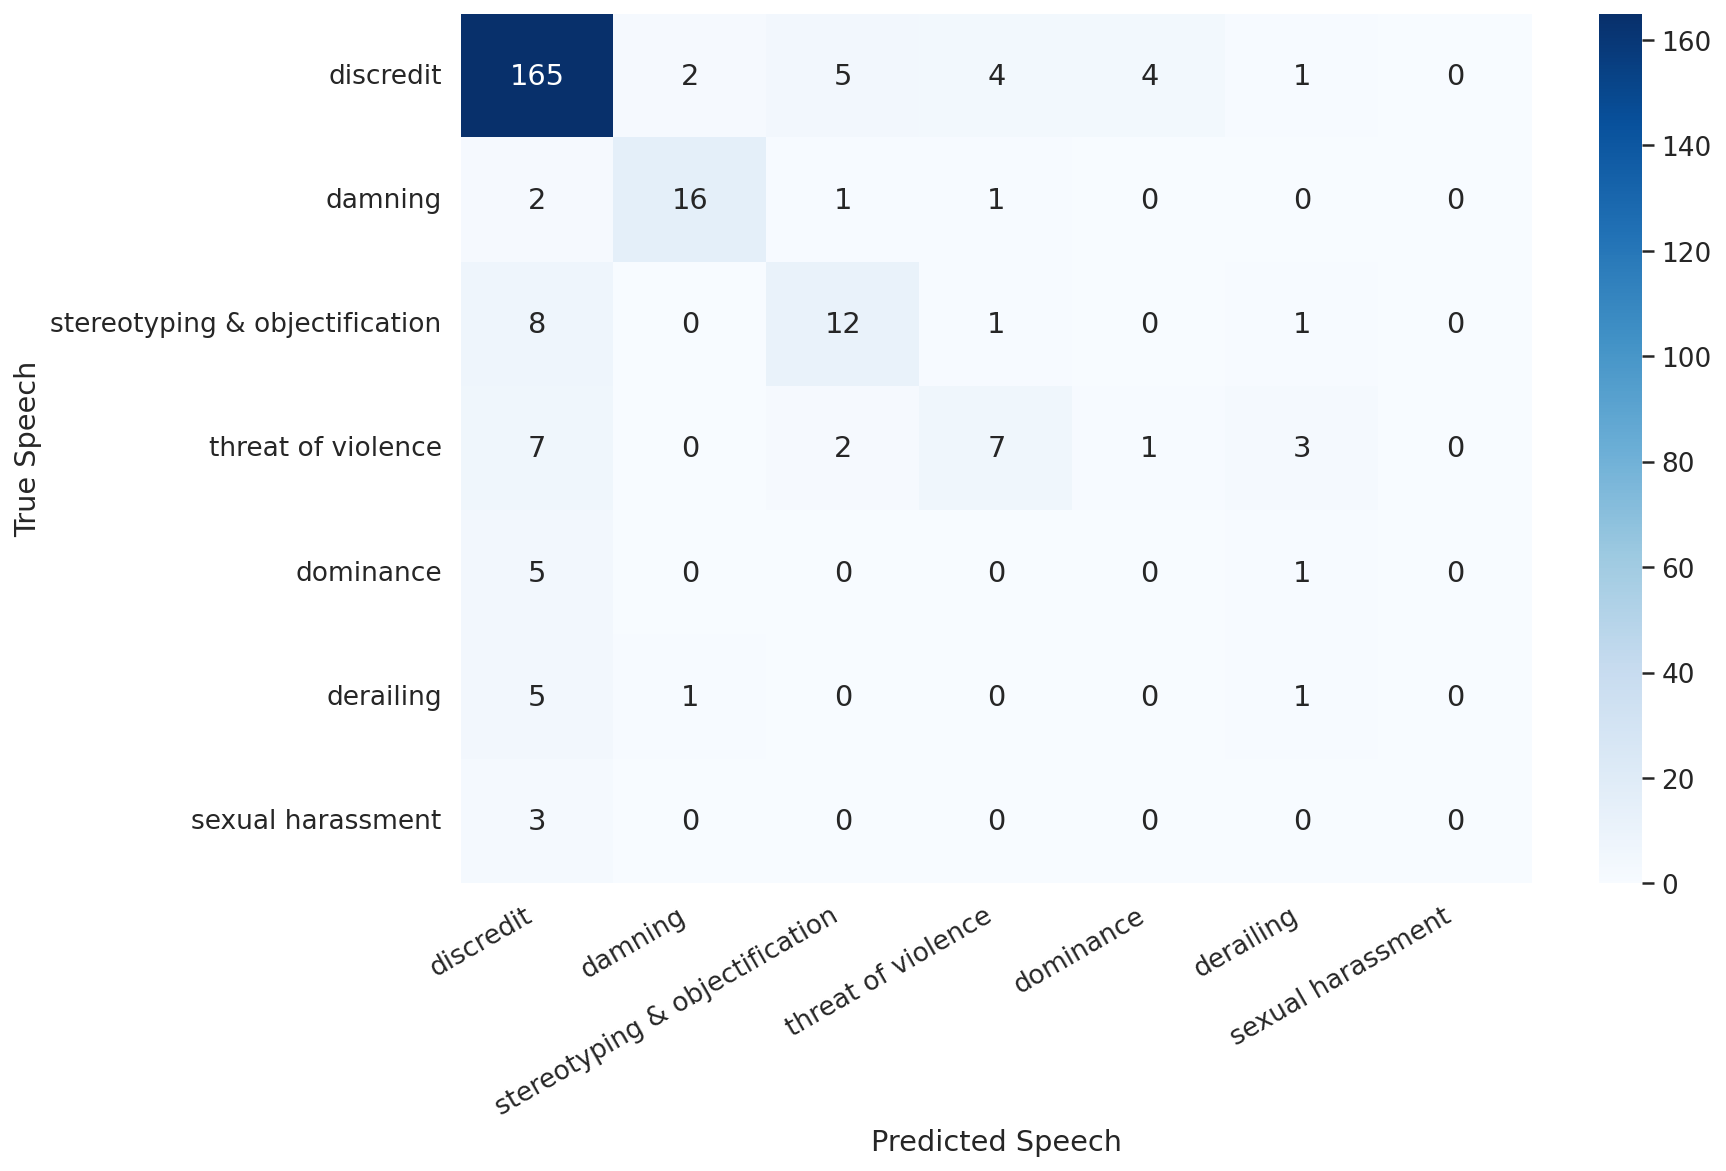

In [63]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Speech')
  plt.xlabel('Predicted Speech');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)